In [ ]:
# Train.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from models.lenet import LeNet
import matplotlib.pyplot as plt

batch_size = 64
lr = 0.01 # learning rate
epochs = 10

# Preprocess

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # 标准化，mean = (0.1307,) std = (0.3081,) x=(x-mean)/std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

losses = []

for epoch in range(epochs):
    model.train() # Switch to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward() # Backward pass
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), 'lenet.pth')
print("Training complete and model saved as lenet.pth")

# draw loss curve

plt.figure()
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.title('Training Loss Curve')
plt.grid(True)
plt.savefig('loss_curve.png')
plt.show()

## Without FGSM

- Epoch [1/10], Loss: 0.3945
- Epoch [2/10], Loss: 0.0849
- Epoch [3/10], Loss: 0.0565
- Epoch [4/10], Loss: 0.0454
- Epoch [5/10], Loss: 0.0375
- Epoch [6/10], Loss: 0.0316
- Epoch [7/10], Loss: 0.0286
- Epoch [8/10], Loss: 0.0242
- Epoch [9/10], Loss: 0.0218
- Epoch [10/10], Loss: 0.0189

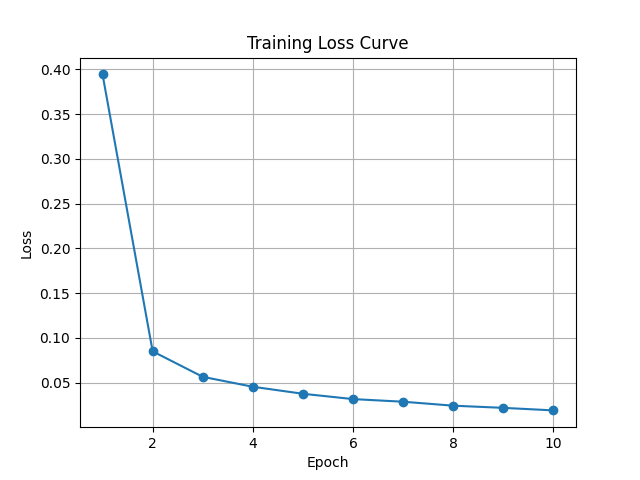

In [ ]:
# Test.py

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from models.lenet import LeNet

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # 标准化，mean = (0.1307,) std = (0.3081,) x=(x-mean)/std
])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
model.load_state_dict(torch.load('lenet.pth', map_location=device))
model.eval()

correct, total = 0, 0

with torch.no_grad(): # banning gradient calculation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

## Without FGSM

Test Accuracy: 99.08%

In [ ]:
## utils.py

import torch

def fgsm(model, loss_fn, images, labels, epsilon):

    images = images.clone().detach().to(images.device)

    images.requires_grad = True

    outputs = model(images)
    loss = loss_fn(outputs, labels)

    model.zero_grad()
    loss.backward()

    grad_sign = images.grad.sign()

    atk_images = images + epsilon * grad_sign
    
    return atk_images


In [ ]:
## fgsm_atk.py

import torch
from utils import fgsm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from models.lenet import LeNet
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

epsilon_values = [0.00, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # 标准化，mean = (0.1307,) std = (0.3081,) x=(x-mean)/std
])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
model.load_state_dict(torch.load('lenet.pth', map_location=device))
model.eval()

loss_fn = torch.nn.CrossEntropyLoss()

accuracies = []

for epsilon in epsilon_values:

    correct, total = 0, 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        atk_images = fgsm(model, loss_fn, images, labels, epsilon)

        outputs = model(atk_images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracies.append(100 * correct / total)
    print(f"Epsilon: {epsilon:.2f} Test Accuracy: {100 * correct / total:.2f}%")

plt.figure()
plt.plot(epsilon_values, accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy(%)')
plt.title('FGSM Attack Effect on Model Accuracy')
plt.grid(True)
plt.savefig('fgsm_attack.png')
plt.show()

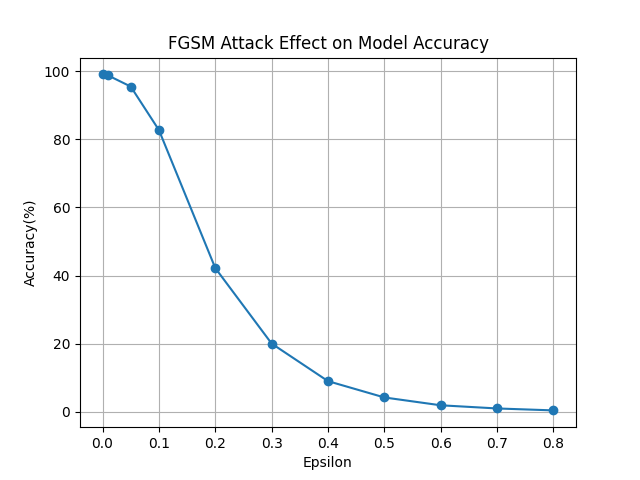

## With FGSM Attack

Epsilon: 0.00 Test Accuracy: 99.08%
Epsilon: 0.01 Test Accuracy: 98.76%
Epsilon: 0.05 Test Accuracy: 95.51%
Epsilon: 0.10 Test Accuracy: 82.75%
Epsilon: 0.20 Test Accuracy: 42.22%
Epsilon: 0.30 Test Accuracy: 20.04%
Epsilon: 0.40 Test Accuracy: 9.01%
Epsilon: 0.50 Test Accuracy: 4.22%
Epsilon: 0.60 Test Accuracy: 1.92%
Epsilon: 0.70 Test Accuracy: 0.99%
Epsilon: 0.80 Test Accuracy: 0.42%

In [ ]:
## fgsm_train.py
## epsilon = 0.3

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from models.lenet import LeNet
import matplotlib.pyplot as plt
from utils import fgsm
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

batch_size = 64
lr = 0.01 #learning rate
epochs = 10

# Preprocess

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # 标准化，mean = (0.1307,) std = (0.3081,) x=(x-mean)/std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

losses = []

for epoch in range(epochs):
    model.train() # Switch to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        atk_images = fgsm(model, criterion, images, labels, epsilon=0.3)

        mixed_images = torch.cat((images, atk_images), 0)
        mixed_labels = torch.cat((labels, labels), 0)
        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model(mixed_images)
        loss = criterion(outputs, mixed_labels)
        loss.backward() # Backward pass
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), 'lenet_fgsm.pth')
print("Training complete and model saved as lenet_fgsm.pth")

# draw loss curve

plt.figure()
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.savefig('loss_curve_fgsm.png')
plt.show()


## Train with FGSM

Epoch [1/10], Loss: 0.6332
Epoch [2/10], Loss: 0.1970
Epoch [3/10], Loss: 0.1428
Epoch [4/10], Loss: 0.1196
Epoch [5/10], Loss: 0.1065
Epoch [6/10], Loss: 0.0957
Epoch [7/10], Loss: 0.0868
Epoch [8/10], Loss: 0.0805
Epoch [9/10], Loss: 0.0742
Epoch [10/10], Loss: 0.0711

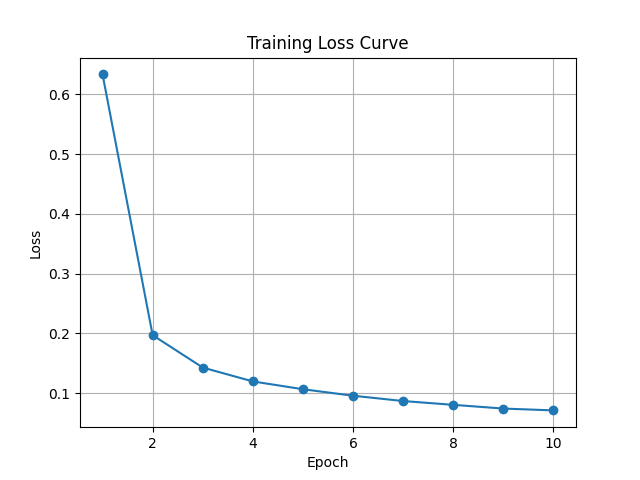

In [ ]:
## fgsm_attack_after_train.py

import torch
from utils import fgsm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from models.lenet import LeNet
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

epsilon_values = [0.00, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # 标准化，mean = (0.1307,) std = (0.3081,) x=(x-mean)/std
])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
model.load_state_dict(torch.load('lenet_fgsm.pth', map_location=device))
model.eval()

loss_fn = torch.nn.CrossEntropyLoss()

accuracies = []

for epsilon in epsilon_values:

    correct, total = 0, 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        atk_images = fgsm(model, loss_fn, images, labels, epsilon)

        outputs = model(atk_images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracies.append(100 * correct / total)
    print(f"Epsilon: {epsilon:.2f} Test Accuracy: {100 * correct / total:.2f}%")

plt.figure()
plt.plot(epsilon_values, accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy(%)')
plt.title('FGSM Attack Effect on Model Accuracy')
plt.grid(True)
plt.savefig('fgsm_attack_after_train.png')
plt.show()

Epsilon: 0.00 Test Accuracy: 98.78%
Epsilon: 0.01 Test Accuracy: 98.73%
Epsilon: 0.05 Test Accuracy: 98.36%
Epsilon: 0.10 Test Accuracy: 97.92%
Epsilon: 0.20 Test Accuracy: 96.77%
Epsilon: 0.30 Test Accuracy: 95.36%
Epsilon: 0.40 Test Accuracy: 93.54%
Epsilon: 0.50 Test Accuracy: 90.94%
Epsilon: 0.60 Test Accuracy: 87.18%
Epsilon: 0.70 Test Accuracy: 82.54%
Epsilon: 0.80 Test Accuracy: 75.45%

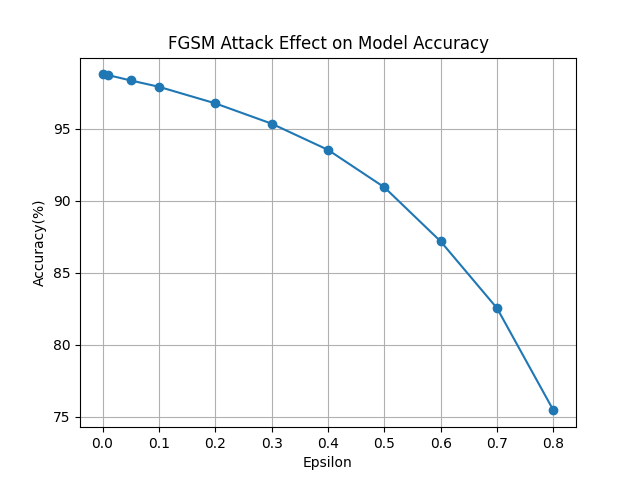